In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import numpy as np
import re
import nltk
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import logging
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\syadav18\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
import logging
logging.basicConfig(level=logging.DEBUG, filename='complaints.log', 
                    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

In [3]:
try:
    df = pd.read_csv('consumer_compliants/consumer_compliants.csv')
    logging.info("CSV file read successfully")
except Exception as e:
    logging.error("Error reading the CSV file", exc_info=True)

### LOADING DATASET

I have taken dataset of consumer complaints on products for that particular company. There are 6 different products, 57453 rows. I have taken 3 rows i.e., products, Consumer complaint narrative, Company which are mainly important. And here we can see that there is a imbalance in the data. There are 21772 value count for debit collection where as for Vehicle loan or lease there is only 2736 value count.

In [33]:
df.head(1)

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,4/3/2020,Vehicle loan or lease,Loan,Getting a loan or lease,Fraudulent loan,"This auto loan was opened on XX/XX/2020 in XXXX, NC with BB & T in my name. I have NEVER been to North Carolina and I have NEVER been a resident. I have filed a dispute twice through my credit bureaus but both times BB & T has claimed that this is an accurate loan. Which I wasn't aware of until today. I have tried to contact BB & T multiple times but I have never gotten through to a live person. I do n't drive and I have never owned a car before. I didn't have any knowledge of this account until I checked XXXXXXXX XXXX and noticed it. I've tried twice to dispute it. Additionally I never received any bills or information about this account. This is my last resort in trying to remove this fraudulent loan off of my account.",Company has responded to the consumer and the CFPB and chooses not to provide a public response,TRUIST FINANCIAL CORPORATION,PA,None,None,Consent provided,Web,4/3/2020,Closed with explanation,Yes,NaN,3591341


In [34]:
df['Consumer complaint narrative'].head(1)

0    This auto loan was opened on XX/XX/2020 in XXXX, NC with BB & T in my name. I have NEVER been to North Carolina and I have NEVER been a resident. I have filed a dispute twice through my credit bureaus but both times BB & T has claimed that this is an accurate loan. Which I wasn't aware of until today. I have tried to contact BB & T multiple times but I have never gotten through to a live person. I do n't drive and I have never owned a car before. I didn't have any knowledge of this account until I checked XXXXXXXX XXXX  and noticed it. I've tried twice to dispute it. Additionally I never received any bills or information about this account. This is my last resort in trying to remove this fraudulent loan off of my account.
Name: Consumer complaint narrative, dtype: object

In [35]:
df['Product'].value_counts()

Debt collection                21772
Credit card or prepaid card    13193
Mortgage                       9799 
Checking or savings account    7003 
Student loan                   2950 
Vehicle loan or lease          2736 
Name: Product, dtype: int64

<Axes: >

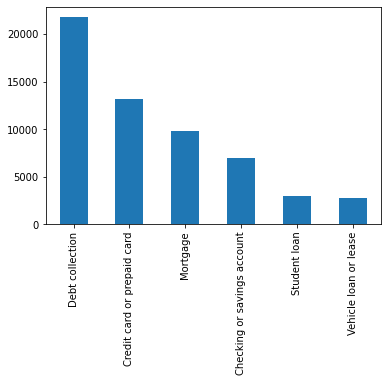

In [36]:
df['Product'].value_counts().plot(kind = 'bar')

In [37]:
df['Product'].isnull().sum()

0

In [38]:
df['Company'].value_counts()

CITIBANK, N.A.                           3226
CAPITAL ONE FINANCIAL CORPORATION        2711
BANK OF AMERICA, NATIONAL ASSOCIATION    2580
JPMORGAN CHASE & CO.                     2409
WELLS FARGO & COMPANY                    2001
                                         ... 
Dalty Acquisitions, Inc.                 1   
NewFed Mortgage Corp                     1   
CDI Affiliated Services, Inc.            1   
Schreiber Law LLC                        1   
Infinity Capital Group                   1   
Name: Company, Length: 2197, dtype: int64

In [4]:
try:
    complaints_df = df[['Consumer complaint narrative', 'Product', 'Company']].rename(columns={'Consumer complaint narrative': 'complaints'})
    logging.info("Selected relevant columns and renamed them")
    logging.debug(f"DataFrame after renaming columns:\n{complaints_df.head()}")
except Exception as e:
    logging.error("Error selecting and renaming columns", exc_info=True)

In [5]:
try:
    pd.set_option('display.max_colwidth', -1)
    logging.info("Set pandas display option for max column width")
except Exception as e:
    logging.error("Error setting pandas display options", exc_info=True)

<ipython-input-5-5119f62fa9b8>:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [39]:
complaints_df

,complaints,Product,Company,target
0,"This auto loan was opened on XX/XX/2020 in XXXX, NC with BB & T in my name. I have NEVER been to North Carolina and I have NEVER been a resident. I have filed a dispute twice through my credit bureaus but both times BB & T has claimed that this is an accurate loan. Which I wasn't aware of until today. I have tried to contact BB & T multiple times but I have never gotten through to a live person. I do n't drive and I have never owned a car before. I didn't have any knowledge of this account until I checked XXXXXXXX XXXX and noticed it. I've tried twice to dispute it. Additionally I never received any bills or information about this account. This is my last resort in trying to remove this fraudulent loan off of my account.",Vehicle loan or lease,TRUIST FINANCIAL CORPORATION,5
1,"In XXXX of 2019 I noticed a debt for {$620.00} on my credit which i believed was mine I thought speedy cash had bought one of my old debts and sold it to XXXX XXXX XXXX XXXX. I contacted XXXX XXXX XXXX XXXX and after several attempts of giving my full name, nothing came up in their system. I gave my social and the rep said the account popped up but DID NOT tell me that the account was under someone elses name and continued to let me make a payment. The payment was for {$120.00}. Confirmation number-XXXX. After realizing it was not my account, I called back to get my money back and inform them of the mistake. I was told i needed to mail them an FTC report and dispute letter to get my money back. I completed all of this and when i called again they said they transferred the account back to speedy cash for fraud review and I would need to contact them. After contacting them i was again told that i can not get my money back. The issue im having is this representative at XXXX XXXX played blind to obvious fraud and let an innocent person make a payment on someone elses debt and i want my money back.",Debt collection,CURO Intermediate Holdings,0
2,"As stated from Capital One, XXXX XX/XX/XXXX and XXXX 2018, My wife and I went to several car dealerships to request for a car loan to get a used car. However, according to their credit requirements unfortunately my credit score was insufficient for the car loan approval at that time. It seemed as though they pulled my credit report multiple times.",Vehicle loan or lease,CAPITAL ONE FINANCIAL CORPORATION,5
3,"Please see CFPB case XXXX. \n\nCapital One, in the letter they provided ( and attached to that case as their response ) said this : "" The funds were reversed and sent back to XXXX XXXX XXXX on XX/XX/XXXX ''. \n\nXXXX XXXX XXXX ( now XXXX XXXX ) has not received these funds. Staff at XXXX XXXX - and also staff at the account-holder 's business - have looked for return of my money ( {$650.00} ) and find nothing. \n\nCapital One needs to document - actually prove - they returned the funds, as stated in their letter. Capital One must provide electronic information, if the return was made that way, or document the paper check they sent back to XXXX XXXX. \n\nI've left 3 messages about this problem for the person who signed the letter ( XXXX ) from Capital One. I have received no call-backs. \n\nSummary : Capital One said they returned my money on XX/XX/XXXX : they did not. If they continue claim they did, then they need to prove that.",Checking or savings account,CAPITAL ONE FINANCIAL CORPORATION,3
4,"This debt was incurred due to medical malpractice ( XXXX XXXX XXXX, XXXX, TX ). I asked the doctor to turn over my claim to his malpractice insurance company. This has cost me thousands of dollars to XXXX XXXX XXXX. I am still trying to collect damages from this doctor. He never responded and turned over me to collections Merchants and Professional Collection Bureau , Inc. I sent them a letter describing exactly this issue and instead of not contacting me and verifying my debt they start reporting this debt to the credit reporting agencies. They never verified the debt, like I asked

Mapping the products class into 6 unique targets.

In [6]:
try:
    target = {'Debt collection': 0, 'Credit card or prepaid card': 1, 'Mortgage': 2, 'Checking or savings account': 3, 'Student loan': 4, 'Vehicle loan or lease': 5}
    complaints_df['target'] = complaints_df['Product'].map(target)
    logging.info("Mapped product names to target labels")
    logging.debug(f"DataFrame after mapping target:\n{complaints_df.head()}")
except Exception as e:
    logging.error("Error mapping product names to target labels", exc_info=True)

In [7]:
target

{'Debt collection': 0,
 'Credit card or prepaid card': 1,
 'Mortgage': 2,
 'Checking or savings account': 3,
 'Student loan': 4,
 'Vehicle loan or lease': 5}

### TRAIN AND TEST SPLIT

Split the dataset into train and test in ratio of 20:80.

In [8]:
try:
    X_train, X_test = train_test_split(complaints_df, test_size=0.8, random_state=111)
    logging.info("Split data into train and test sets")
    logging.debug(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
except Exception as e:
    logging.error("Error splitting data into train and test sets", exc_info=True)

### EDA

1. Pre processing the text by nltk stop words.
2. Stemming is used when the context is not so important. So here the customer complaints narrative has no much imporatance.
3. Tokenizing the text. 
4. Used TF-IDF to vectorize the text.

In [9]:
try:
    # stemmer = PorterStemmer()
    stemmer = nltk.stem.SnowballStemmer('english')
    logging.info("Initialized the Snowball stemmer")
except Exception as e:
    logging.error("Error initializing the Snowball stemmer", exc_info=True)

In [10]:
try:
    nltk.download('stopwords')
    stop_words = set(nltk.corpus.stopwords.words('english'))
    logging.info("Downloaded NLTK stopwords")
except Exception as e:
    logging.error("Error downloading NLTK stopwords", exc_info=True)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\syadav18\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
try:
    def tokenize(text):
        tokens = [word for word in nltk.word_tokenize(text) if (len(word) > 3 and len(word.strip('Xx/')) > 2 and len(re.sub('\d+', '', word.strip('Xx/'))))]
        tokens = map(str.lower, tokens)
        stems = [stemmer.stem(item) for item in tokens if (item not in stop_words)]
        return stems
    logging.info("Defined the tokenize function")
except Exception as e:
    logging.error("Error defining the tokenize function", exc_info=True)

In [12]:
try:
    vectorizer_tf = TfidfVectorizer(tokenizer=tokenize, stop_words=None, max_df=0.75, max_features=1000, lowercase=False, ngram_range=(1, 2))
    train_vectors = vectorizer_tf.fit_transform(X_train.complaints)
    logging.info("Initialized the TfidfVectorizer and transformed the training data")
    logging.debug(f"TF-IDF feature names:\n{vectorizer_tf.get_feature_names_out()}")
except Exception as e:
    logging.error("Error initializing the TfidfVectorizer and transforming the training data", exc_info=True)

C:\Users\syadav18\AppData\Roaming\Python\Python38\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [40]:
train_vectors.A

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.47302682, 0.        , ..., 0.        , 0.        ,
        0.08561356],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [13]:
vectorizer_tf.get_feature_names_out()

array(['0.00', '100.00', '1000.00', '1500.00', '200.00', '2000.00',
       '300.00', '500.00', 'abil', 'abl', 'absolut', 'abus', 'accept',
       'access', 'accord', 'account', 'account account', 'account balanc',
       'account call', 'account close', 'account credit',
       'account number', 'account open', 'account report',
       'account would', 'accru', 'acct', 'accur', 'acknowledg', 'action',
       'activ', 'actual', 'ad', 'addit', 'address', 'adjust', 'admit',
       'advanc', 'advertis', 'advis', 'affect', 'affidavit', 'afford',
       'agenc', 'agent', 'agre', 'agreement', 'alert', 'alleg',
       'alleg debt', 'alli', 'allow', 'almost', 'along', 'alreadi',
       'also', 'although', 'alway', 'america', 'american',
       'american express', 'amex', 'amount', 'amount owe', 'and/or',
       'annual', 'anoth', 'answer', 'anyon', 'anyth', 'apart', 'appar',
       'appeal', 'appear', 'appli', 'applic', 'apprais', 'appreci',
       'approv', 'approxim', 'around', 'arrang', 'arr

In [14]:
try:
    test_vectors = vectorizer_tf.transform(X_test.complaints)
    logging.info("Transformed the test data")
except Exception as e:
    logging.error("Error transforming the test data", exc_info=True)

In [15]:
X_train.shape

(11490, 4)

In [16]:
try:
    train_df = pd.DataFrame(train_vectors.toarray(), columns=vectorizer_tf.get_feature_names_out())
    train_df = pd.concat([train_df, X_train['target'].reset_index(drop=True)], axis=1)
    logging.info("Created the training DataFrame")
    logging.debug(f"Training DataFrame:\n{train_df.head()}")
except Exception as e:
    logging.error("Error creating the training DataFrame", exc_info=True)

In [17]:
try:
    test_df = pd.DataFrame(test_vectors.toarray(), columns=vectorizer_tf.get_feature_names_out())
    test_df = pd.concat([test_df, X_test['target'].reset_index(drop=True)], axis=1)
    logging.info("Created the test DataFrame")
    logging.debug(f"Test DataFrame:\n{test_df.head()}")
except Exception as e:
    logging.error("Error creating the test DataFrame", exc_info=True)

### MODEL EVALUATION

1. Precision is favored when false positives have severe consequences.
2. Recall is prioritized when false negatives are unacceptable.
3. Common approach to balance these metrics is the F1 score, which is the harmonic mean of precision and recall and provides a single measure that balances the two.

As we can see that the data is imbalanced and checking for accuracy can be misleading. So we use F1 score for imbalanced datasets because it provides a balance between precision and recall.

Confusion matrix provides a detailed breakdown of true positives, false positives, true negatives, and false negatives.

I have built 4 model Logistic Regression, Random Forest, SVC, Decision Tree.



classification_report :
               precision    recall  f1-score   support

           0       0.89      0.92      0.91     17429
           1       0.84      0.87      0.85     10485
           2       0.91      0.92      0.91      7945
           3       0.85      0.83      0.84      5562
           4       0.90      0.74      0.81      2366
           5       0.83      0.58      0.69      2176

    accuracy                           0.87     45963
   macro avg       0.87      0.81      0.84     45963
weighted avg       0.87      0.87      0.87     45963



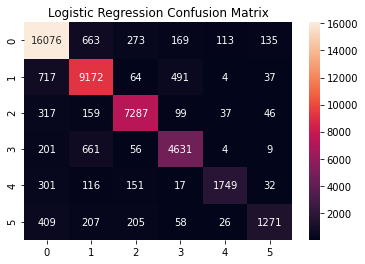

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import seaborn as sns
import matplotlib.pyplot as plt

try:
    lg_clf = LogisticRegression(max_iter=1000, random_state=10)
    lg_clf.fit(train_vectors, X_train['target'])
    logging.info("Trained Logistic Regression model")

    lg_predictions = lg_clf.predict(test_vectors)
    logging.info("Made predictions with Logistic Regression model")

    cm = confusion_matrix(X_test['target'], lg_predictions)
    logging.debug(f"Confusion Matrix:\n{cm}")
    print('classification_report :\n', classification_report(X_test['target'], lg_predictions))

    cm_matrix = pd.DataFrame(data=cm)
    sns.heatmap(cm_matrix, annot=True, fmt='d')
    plt.title('Logistic Regression Confusion Matrix')
    plt.show()
except Exception as e:
    logging.error("Error with Logistic Regression model", exc_info=True)

classification_report :
               precision    recall  f1-score   support

           0       0.90      0.92      0.91     17429
           1       0.84      0.89      0.86     10485
           2       0.90      0.92      0.91      7945
           3       0.86      0.84      0.85      5562
           4       0.91      0.72      0.81      2366
           5       0.83      0.58      0.68      2176

    accuracy                           0.88     45963
   macro avg       0.87      0.81      0.84     45963
weighted avg       0.88      0.88      0.87     45963



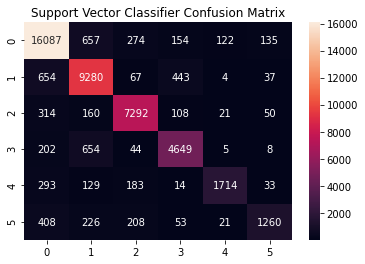

In [19]:
try:
    svc_clf = SVC(probability=True, random_state=10)
    svc_clf.fit(train_vectors, X_train['target'])
    logging.info("Trained Support Vector Classifier model")

    svc_predictions = svc_clf.predict(test_vectors)
    logging.info("Made predictions with Support Vector Classifier model")

    cm = confusion_matrix(X_test['target'], svc_predictions)
    logging.debug(f"Confusion Matrix:\n{cm}")
    print('classification_report :\n', classification_report(X_test['target'], svc_predictions))

    cm_matrix = pd.DataFrame(data=cm)
    sns.heatmap(cm_matrix, annot=True, fmt='d')
    plt.title('Support Vector Classifier Confusion Matrix')
    plt.show()
except Exception as e:
    logging.error("Error with Support Vector Classifier model", exc_info=True)

classification_report :
               precision    recall  f1-score   support

           0       0.84      0.84      0.84     17429
           1       0.74      0.75      0.75     10485
           2       0.83      0.81      0.82      7945
           3       0.69      0.68      0.68      5562
           4       0.67      0.67      0.67      2366
           5       0.46      0.46      0.46      2176

    accuracy                           0.77     45963
   macro avg       0.70      0.70      0.70     45963
weighted avg       0.77      0.77      0.77     45963



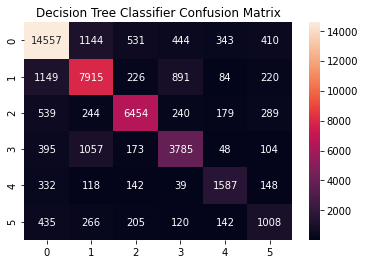

In [20]:
try:
    dtc_clf = DecisionTreeClassifier(random_state=10)
    dtc_clf.fit(train_vectors, X_train['target'])
    logging.info("Trained Decision Tree Classifier model")

    dtc_predictions = dtc_clf.predict(test_vectors)
    logging.info("Made predictions with Decision Tree Classifier model")

    cm = confusion_matrix(X_test['target'], dtc_predictions)
    logging.debug(f"Confusion Matrix:\n{cm}")
    print('classification_report :\n', classification_report(X_test['target'], dtc_predictions))

    cm_matrix = pd.DataFrame(data=cm)
    sns.heatmap(cm_matrix, annot=True, fmt='d')
    plt.title('Decision Tree Classifier Confusion Matrix')
    plt.show()
except Exception as e:
    logging.error("Error with Decision Tree Classifier model", exc_info=True)

classification_report :
               precision    recall  f1-score   support

           0       0.87      0.92      0.89     17429
           1       0.81      0.87      0.84     10485
           2       0.89      0.91      0.90      7945
           3       0.86      0.80      0.83      5562
           4       0.89      0.73      0.80      2366
           5       0.86      0.39      0.54      2176

    accuracy                           0.86     45963
   macro avg       0.86      0.77      0.80     45963
weighted avg       0.86      0.86      0.85     45963



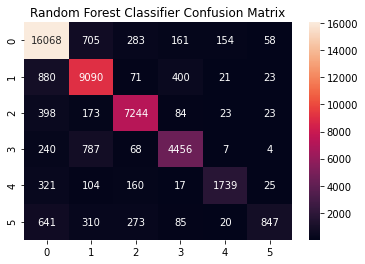

In [21]:
try:
    rf_clf = RandomForestClassifier(random_state=10)
    rf_clf.fit(train_vectors, X_train['target'])
    logging.info("Trained Random Forest Classifier model")

    rf_predictions = rf_clf.predict(test_vectors)
    logging.info("Made predictions with Random Forest Classifier model")

    cm = confusion_matrix(X_test['target'], rf_predictions)
    logging.debug(f"Confusion Matrix:\n{cm}")
    print('classification_report :\n', classification_report(X_test['target'], rf_predictions))

    cm_matrix = pd.DataFrame(data=cm)
    sns.heatmap(cm_matrix, annot=True, fmt='d')
    plt.title('Random Forest Classifier Confusion Matrix')
    plt.show()
except Exception as e:
    logging.error("Error with Random Forest Classifier model", exc_info=True)

### BALANCING THE DATA

We already know the datset is unbalanced so class weights is one of the technique to balance the dataset. Adjust the weights of classes in algorithms to give more importance to the minority class. Minority class has more weight than the majority classes. For example: debit collection has maximum value count so it's weight is 0.44093944278148745, but Vehicle loan or lease is the minority class but has more weight 3.419642857142857.

In [22]:
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight

try:
    class_labels = np.unique(X_train['target'])
    class_weights_array = compute_class_weight(class_weight='balanced', classes=class_labels, y=X_train['target'])
    class_weights = dict(zip(class_labels, class_weights_array))
    logging.info("Computed class weights")
    logging.debug(f"Class Weights: {class_weights}")
except Exception as e:
    logging.error("Error computing class weights", exc_info=True)

In [42]:
print("Class Weights:", class_weights)
print("Unique class labels in target:", class_labels)

Class Weights: {0: 0.44093944278148745, 1: 0.7071639586410635, 2: 1.0329018338727076, 3: 1.328938237335184, 4: 3.279109589041096, 5: 3.419642857142857}
Unique class labels in target: [0 1 2 3 4 5]


In [23]:
try:
    weights = []

    for val in X_train['target']:
        if val in class_weights:
            weights.append(class_weights[val])
        else:
            logging.warning(f"Class label {val} not found in class_weights")
            weights.append(1.0)  # Default weight if class not found

    weights = np.array(weights)
    logging.info("Initialized weights list")
    logging.debug(f"Weights: {weights[:10]}")  # Log only the first 10 for brevity
except Exception as e:
    logging.error("Error initializing weights list", exc_info=True)

In [24]:
print(weights)

[0.44093944 3.41964286 1.32893824 ... 0.70716396 0.70716396 1.03290183]


I have built the same models for balanced dataset but there's no much difference.

Classification Report (Logistic Regression):
               precision    recall  f1-score   support

           0       0.94      0.87      0.91     17429
           1       0.87      0.83      0.85     10485
           2       0.93      0.90      0.92      7945
           3       0.79      0.89      0.84      5562
           4       0.74      0.86      0.80      2366
           5       0.57      0.79      0.66      2176

    accuracy                           0.87     45963
   macro avg       0.81      0.86      0.83     45963
weighted avg       0.88      0.87      0.87     45963



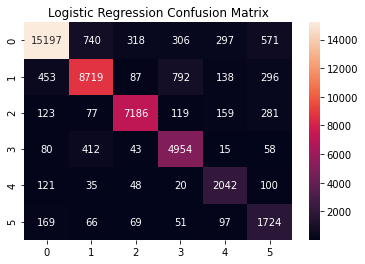

In [25]:
try:
    lg_clf = LogisticRegression(max_iter=1000, random_state=10)
    lg_clf.fit(train_vectors, X_train['target'], sample_weight=weights)
    logging.info("Trained Logistic Regression model")

    lg_predictions = lg_clf.predict(test_vectors)
    logging.info("Made predictions with Logistic Regression model")

    cm = confusion_matrix(X_test['target'], lg_predictions)
    logging.debug(f"Confusion Matrix (Logistic Regression):\n{cm}")
    print('Classification Report (Logistic Regression):\n', classification_report(X_test['target'], lg_predictions))

    cm_matrix = pd.DataFrame(data=cm)
    sns.heatmap(cm_matrix, annot=True, fmt='d')
    plt.title('Logistic Regression Confusion Matrix')
    plt.show()
except Exception as e:
    logging.error("Error with Logistic Regression model", exc_info=True)

Classification Report (Support Vector Classifier):
               precision    recall  f1-score   support

           0       0.92      0.90      0.91     17429
           1       0.85      0.86      0.86     10485
           2       0.91      0.92      0.91      7945
           3       0.82      0.88      0.85      5562
           4       0.78      0.80      0.79      2366
           5       0.73      0.68      0.70      2176

    accuracy                           0.87     45963
   macro avg       0.84      0.84      0.84     45963
weighted avg       0.88      0.87      0.87     45963



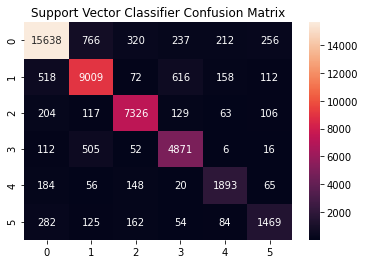

In [26]:
try:
    svc_clf = SVC(probability=True, random_state=10)
    svc_clf.fit(train_vectors, X_train['target'], sample_weight=weights)
    logging.info("Trained Support Vector Classifier model")

    svc_predictions = svc_clf.predict(test_vectors)
    logging.info("Made predictions with Support Vector Classifier model")

    cm = confusion_matrix(X_test['target'], svc_predictions)
    logging.debug(f"Confusion Matrix (Support Vector Classifier):\n{cm}")
    print('Classification Report (Support Vector Classifier):\n', classification_report(X_test['target'], svc_predictions))

    cm_matrix = pd.DataFrame(data=cm)
    sns.heatmap(cm_matrix, annot=True, fmt='d')
    plt.title('Support Vector Classifier Confusion Matrix')
    plt.show()
except Exception as e:
    logging.error("Error with Support Vector Classifier model", exc_info=True)

Classification Report (Decision Tree Classifier):
               precision    recall  f1-score   support

           0       0.83      0.82      0.82     17429
           1       0.75      0.72      0.74     10485
           2       0.82      0.82      0.82      7945
           3       0.67      0.70      0.68      5562
           4       0.69      0.72      0.70      2366
           5       0.48      0.55      0.51      2176

    accuracy                           0.76     45963
   macro avg       0.71      0.72      0.71     45963
weighted avg       0.77      0.76      0.77     45963



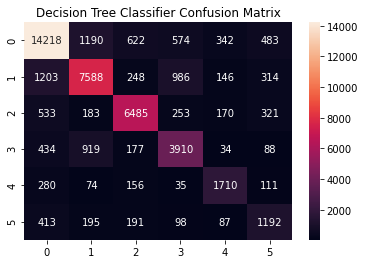

In [27]:
try:
    dtc_clf = DecisionTreeClassifier(random_state=10)
    dtc_clf.fit(train_vectors, X_train['target'], sample_weight=weights)
    logging.info("Trained Decision Tree Classifier model")

    dtc_predictions = dtc_clf.predict(test_vectors)
    logging.info("Made predictions with Decision Tree Classifier model")

    cm = confusion_matrix(X_test['target'], dtc_predictions)
    logging.debug(f"Confusion Matrix (Decision Tree Classifier):\n{cm}")
    print('Classification Report (Decision Tree Classifier):\n', classification_report(X_test['target'], dtc_predictions))

    cm_matrix = pd.DataFrame(data=cm)
    sns.heatmap(cm_matrix, annot=True, fmt='d')
    plt.title('Decision Tree Classifier Confusion Matrix')
    plt.show()
except Exception as e:
    logging.error("Error with Decision Tree Classifier model", exc_info=True)

Classification Report (Random Forest Classifier):
               precision    recall  f1-score   support

           0       0.87      0.91      0.89     17429
           1       0.85      0.84      0.84     10485
           2       0.91      0.91      0.91      7945
           3       0.84      0.83      0.84      5562
           4       0.83      0.81      0.82      2366
           5       0.80      0.55      0.65      2176

    accuracy                           0.86     45963
   macro avg       0.85      0.81      0.83     45963
weighted avg       0.86      0.86      0.86     45963



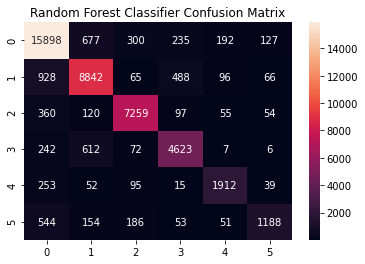

In [28]:
try:
    rf_clf = RandomForestClassifier(random_state=10)
    rf_clf.fit(train_vectors, X_train['target'], sample_weight=weights)
    logging.info("Trained Random Forest Classifier model")

    rf_predictions = rf_clf.predict(test_vectors)
    logging.info("Made predictions with Random Forest Classifier model")

    cm = confusion_matrix(X_test['target'], rf_predictions)
    logging.debug(f"Confusion Matrix (Random Forest Classifier):\n{cm}")
    print('Classification Report (Random Forest Classifier):\n', classification_report(X_test['target'], rf_predictions))

    cm_matrix = pd.DataFrame(data=cm)
    sns.heatmap(cm_matrix, annot=True, fmt='d')
    plt.title('Random Forest Classifier Confusion Matrix')
    plt.show()
except Exception as e:
    logging.error("Error with Random Forest Classifier model", exc_info=True)

### HYPERPARAMETER TUNNING 

Hyperparameters are set before the training process and directly influence the training dynamics and model structure. Proper tuning of hyperparameters can significantly improve the accuracy, generalization, and efficiency of a model.

1. Logistic Regression:
Controls the trade-off between fitting the training data and keeping the model weights small to avoid overfitting. (L1, L2) Determines the type of regularization applied, impacting sparsity and feature selection.

2. Decision tree and random forest:
Number of trees, Minimum samples per leaf, Learning rate (for boosting), Subsampling ratio.

3. SVC:
Regularization parameter, Kernel-specific parameters.

Fitting 3 folds for each of 216 candidates, totalling 648 fits
Classification Report (Best Random Forest Classifier):
               precision    recall  f1-score   support

           0       0.91      0.89      0.90     17429
           1       0.85      0.85      0.85     10485
           2       0.91      0.92      0.92      7945
           3       0.83      0.86      0.84      5562
           4       0.80      0.85      0.83      2366
           5       0.69      0.69      0.69      2176

    accuracy                           0.87     45963
   macro avg       0.83      0.84      0.84     45963
weighted avg       0.87      0.87      0.87     45963

Best Parameters (Random Forest Classifier):
 {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}


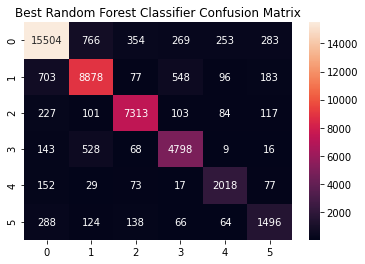

In [29]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
try:
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    }

    grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')
    grid_search.fit(train_vectors, X_train['target'], sample_weight=weights)
    logging.info("Performed Grid Search for Random Forest Classifier")

    best_rf_clf = grid_search.best_estimator_
    predictions = best_rf_clf.predict(test_vectors)
    logging.info("Made predictions with best Random Forest Classifier model")

    cm = confusion_matrix(X_test['target'], predictions)
    logging.debug(f"Confusion Matrix (Best Random Forest Classifier):\n{cm}")
    print('Classification Report (Best Random Forest Classifier):\n', classification_report(X_test['target'], predictions))
    print("Best Parameters (Random Forest Classifier):\n", grid_search.best_params_)

    cm_matrix = pd.DataFrame(data=cm)
    sns.heatmap(cm_matrix, annot=True, fmt='d')
    plt.title('Best Random Forest Classifier Confusion Matrix')
    plt.show()
except Exception as e:
    logging.error("Error with Grid Search for Random Forest Classifier", exc_info=True)

In [30]:
predictions_proba = best_rf_clf.predict_proba(test_vectors)

### ROC - AUC Curve

The ROC curve plots the true positive rate (recall) against the false positive rate. The area under the ROC curve (AUC-ROC) provides a measure of the model's ability to discriminate between the positive and negative classes.

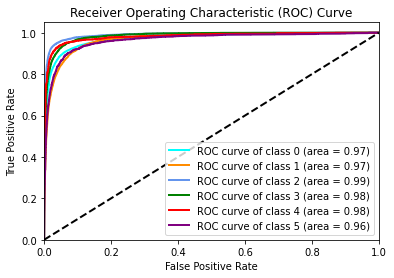

In [31]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, roc_auc_score

try:
    n_classes = len(class_labels)
    y_test_binarized = label_binarize(X_test['target'], classes=class_labels)
    logging.info("Binarized the test target labels")

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], predictions_proba[:, i])
        roc_auc[i] = roc_auc_score(y_test_binarized[:, i], predictions_proba[:, i])
        logging.debug(f"Class {i}: FPR - {fpr[i]}, TPR - {tpr[i]}, ROC AUC - {roc_auc[i]}")

    # Plot ROC curves
    plt.figure()
    colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple']
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, 
                 label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    logging.info("Plotted ROC-AUC curves successfully")
except Exception as e:
    logging.error("Error generating or plotting ROC-AUC curves", exc_info=True)

In [32]:
print("Best Parameters:\n", grid_search.best_params_)

Best Parameters:
 {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
